# Network measurement laboratory - report 4


## Introduction

This assignment aims to analyze the output of *Tstat*, a free open-source passive network monitoring tool, while it was monitoring traffic in the Politecnico's internal network in 2015. 
The first Task, common to all working groups, targets the analysis of TCP connections in a general way while the second Task is group specific and aims to a deeper investigation of a given webservice. For us, the chosen webservice is **Spotify**.

## Task 1



### 1.1

For this exercise we needed to compute the number of *local* clients' TCP connections directed towards all the unique services matching the string _*facebbok.com_ and to plot them in a barplot. Moreover we were asked to plot them in decreasing order and only the top-20. The match has been done considering first what reported in column 127 (namely *fqdn:127*), then, in the case of no match, column 131 (namely *http_hostname:131*), 116 (namely *c_tls_SNI:116*) and 117 (namely *s_tls_SCN:117*) in this sequential order.

In order to fulfill the requirements some lines of code must be added. First the necessary libraries must be imported (*pandas* and *matplotlib*) and we also defined two methods which had to be used within *pandas.DataFrame.apply()* method and which are very useful to obtain the wanted results.

In [1]:
# Import useful libraries
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Define useful methods to be used with pandas.DataFrame.apply() method
def find_match(row):
    
    string = 'facebook.com'
    
    if string in row['fqdn:127']:
        return row['fqdn:127']
    
    elif string in row['http_hostname:131']:
        return row['http_hostname:131']
    
    elif string in row['c_tls_SNI:116']:
        return row['c_tls_SNI:116']
    
    else :
        return row['s_tls_SCN:117']
    

def find_match_regex(row):
    
    string = 'facebook'
    
    if string in row['fqdn:127']:
        return row['fqdn:127']
    
    elif string in row['http_hostname:131']:
        return row['http_hostname:131']
    
    elif string in row['c_tls_SNI:116']:
        return row['c_tls_SNI:116']
    
    else :
        return row['s_tls_SCN:117']

Once the libraries are correctly imported and the methods successfully defined, we can proceed to import the file. Due to its huge dimensions, it is unfeasible to load it at once. Therefore, we proceed analyzing it in chunks of 100000 rows.

In [3]:
# Read file CSV
# dataf = pd.read_csv('log_tcp_complete.xz', sep=' ', nrows=100000)    # used for preliminary results
df_iter = pd.read_csv('log_tcp_complete.xz', sep=" ", iterator=True, chunksize=100000)

# Filter DataFrame for "/*facebook.com"
fb_string = '/*facebook.com'        # define string to be matched
fb_dataf = pd.DataFrame()           # define new dataframe to be used for evaluations
tmp = pd.DataFrame()                # define support dataframe

for chunk in df_iter:
    tmp = chunk[(chunk['c_isint:38'] == 1) &
                ((chunk['fqdn:127'].str.contains(fb_string)) |
                 (chunk['http_hostname:131'].str.contains(fb_string)) |
                 (chunk['c_tls_SNI:116'].str.contains(fb_string)) |
                 (chunk['s_tls_SCN:117'].str.contains(fb_string))
               )]
    fb_dataf = pd.concat([fb_dataf, tmp])
    
# print(fb_dataf)

For every chunk of read file we filter it according to the previously mentioned parameters. Thanks to `chunk['c_isint:38'] == 1` in fact, we select only internal clients in the network and with the subsequent lines of code we search for those connections which have a match for the desired string in one of the 4 columns of interest.
Then, we apply to the whole filtered dataframe (`DataFrame.apply()`) the previously defined method `find_match(row)`, which returns a string of services names including the string _*facebbok.com_. This is useful because we then can add this list of names to our dataframe, in order to simplify the analysis and the plot.

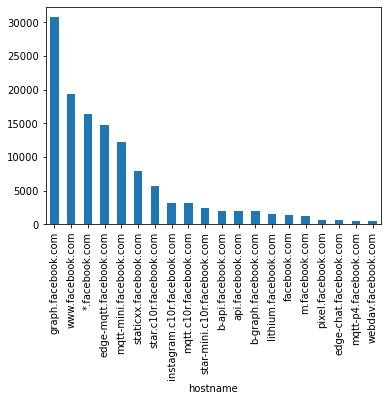

In [7]:
new_col = fb_dataf.apply(find_match, axis=1)
# new_col
fb_dataf.insert(len(fb_dataf.columns), 'hostname', new_col)
# fb_dataf 

# Group and plot
fb_service = fb_dataf.groupby(['hostname']).size()
# fb_service
barplot = fb_service.sort_values(ascending=False).head(20).plot(kind='bar')

Once added the new column to the dataframe, we can then use the method `DataFrame.groupby()` to group them according to some parameter. Since we are asked to find the number of distinct services to which internal hosts are connected to, we group them according to the newly created column *hostname*. In this case we want to know the total number of connections towards each service, therefore we exploit the method `size()` to retrieve it. Afterwards we plot the first 20 highest used services in descending order using bars.

Observing the plot the service with the most TCP connections is *graph.facebook.com*. By a deeper investigation on what the domain represented it resulted to be:
>The Graph API is the primary way to get data into and out of the Facebook platform. It's an HTTP-based API that apps can use to programmatically query data, post new stories, manage ads, upload photos, and perform a wide variety of other tasks. - *https://developers.facebook.com/docs/graph-api/overview*

Consequently, the reason why it has the most connections becomes clear. 
Surprisngly for us, it has more than 10000 more connections than the main service *www.facebook.com*. Among the other services depicted in the plot it is interesting the presence in the first positions of *edge-mqtt.facebook.com*, *mqtt-mini.facebook.com*, *staticxx.facebook.com* and *star.c10r.facebook.com* which are Facebook's trackers: the sum of all of them reaches more than 40000 connections! Moreover even after these ones there are some others reported in the plot, meaning that a great part of the traffic between clients and Facebook's services implies a lot of tracking, which may not be something wanted nor safe for the users. Then, we can also observe some traffic to some *Instagram* service (through Facebook domain) and some other Facebook's APIs services.

Afterwards, we proceed to test the regex concept making the experiment again, but using _\*facebook\*_ as string for the search and the method `find_match_regex` defined previously to obtain more matches in the dataframe.

In [ ]:
df_iter = pd.read_csv('log_tcp_complete.xz', sep=" ", iterator=True, chunksize=100000)

# Filter DataFrame for "/*facebook*"
fb_string_reg = '/*facebook*'
fb_dataf_reg = pd.DataFrame()           # define new dataframe to be used for evaluations
tmp = pd.DataFrame()                    # define support dataframe

for chunk in df_iter:
    tmp = chunk[(chunk['c_isint:38'] == 1) &
               ((chunk['fqdn:127'].str.contains(fb_string_reg)) |
                (chunk['http_hostname:131'].str.contains(fb_string_reg)) |
                (chunk['c_tls_SNI:116'].str.contains(fb_string_reg)) |
                (chunk['s_tls_SCN:117'].str.contains(fb_string_reg))
               )]
    fb_dataf_reg = pd.concat([fb_dataf_reg, tmp])
    
# print(fb_dataf)

new_col = fb_dataf_reg.apply(find_match_regex, axis=1)
# new_col
fb_dataf_reg.insert(len(fb_dataf_reg.columns), 'hostname', new_col)
# fb_dataf_reg 

# Group and plot
fb_service_reg = fb_dataf_reg.groupby(['hostname']).size()
# fb_service
barplot_reg = fb_service_reg.sort_values(ascending=False).head(20).plot(kind='bar')

What are the top-15 most used services in general (without any filter on local client or service), in terms 
of TCP connections? Plot them as a barplot, ordered by decreasing number of TCP connections.


In [8]:
# 15 most used services in general
# Group and plot
# dataf = dataf.groupby(['http_hostname:131']).size()
# fb_service
# barplot = dataf.sort_values(ascending=False).head(15).plot(kind='bar')

# 15 most used TCP services in general
# Group and plot
def find_TCP(row):
    string = '-'
    if string not in row['http_hostname:131']:
        return row['http_hostname:131']
    elif string not in row['fqdn:127']:
        return row['fqdn:127']
    elif string not in row['c_tls_SNI:116']:
        return row['c_tls_SNI:116']
    elif string not in row['s_tls_SCN:117']:
        return row['s_tls_SCN:117']
    
top15 = pd.DataFrame()    
top15['tcp'] = dataf.apply(find_TCP, axis=1)
# top15

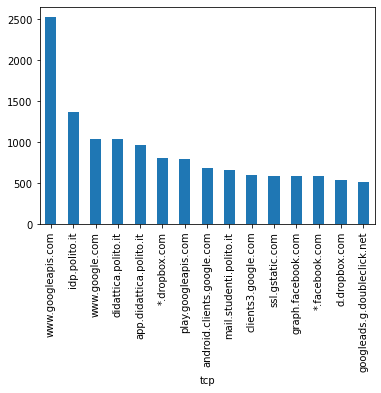

In [9]:
top15_all = top15.groupby(['tcp']).size()
barplot = top15_all.sort_values(ascending=False).head(15).plot(kind='bar')

2a) What happens if you repeat the exercise considering only HTTPS connections?

Dalla tabella nel file si legge solo che colonna 42=1 vuol dire HTTP ma non viene menzionato HTTPS -> dovrebbe essere TLS

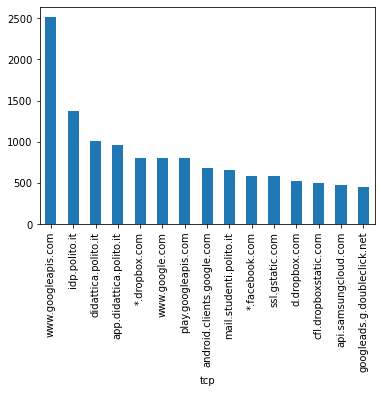

In [10]:
# # 15 most used services for HTTP connections
# # Group and plot
# dataf_HTTP = dataf[(dataf['con_t:42']==1)].groupby(['http_hostname:131']).size()
# # fb_service
# barplot = dataf_HTTP.sort_values(ascending=False).head(15).plot(kind='bar')

# 15 most used TCP services in general using HTTPS (TLS)
# Filter DataFrame for TLS
top15_tls = pd.DataFrame()
top15_tls['tcp'] = dataf[(dataf['con_t:42'] == 8192)].apply(find_TCP, axis=1)
# top15_https
top15_https = top15_tls.groupby(['tcp']).size()
barplot = top15_https.sort_values(ascending=False).head(15).plot(kind='bar')

Count the fraction of connections for different “connection type” (without any filter on local client or
service). Plot the results as a barplot.

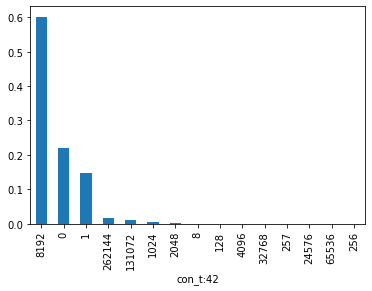

In [11]:
# Count the fraction of connections for different “connection type”
connections = dataf.groupby(['con_t:42']).size()
# Normalize and plot
connections = connections/connections.sum()
barplot = connections.sort_values(ascending=False).plot.bar(stacked=True)

Divide the rows of the file in sequential groups of 100000 connections (or smaller when not working on
the whole trace). Do not use any filter on local client or service. Count the fraction of HTTP flows for each of
these groups. Then plot the series of these fractions (number of the group on the x-axis, fraction of HTTP
connections on the y-axis).
Then report on the previous plot also the fraction of HTTPS connections for each group.
Finally report on the previous plot also the fraction of other protocol flows for each group.
Comment on the plot. Are there more HTTP or HTTPS flows? Are they stable in time?

In [ ]:
# occhio a unnare questa che ci mette 50 anni, il prof dice che è ok
df_iter = pd.read_csv('log_tcp_complete.xz', sep=" ", iterator=True, chunksize=100000)

rates_HTTP = []
rates_HTTPS = []
for chunk in df_iter:
    rates_HTTP.append(chunk[(chunk['con_t:42'] == 1)].shape[0]/chunk.shape[0])
    rates_HTTPS.append(chunk[(chunk['con_t:42'] == 8192)].shape[0]/chunk.shape[0])

plt.plot(rates_HTTP)
plt.plot(rates_HTTPS)
plt.show()

# Task 2

<AxesSubplot:xlabel='con_t:42'>

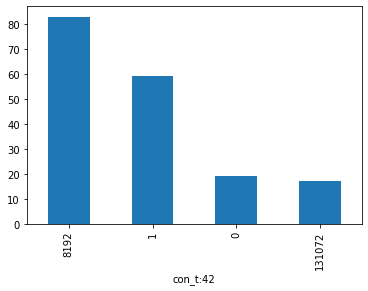

In [5]:
def find_spotify(row):
    string = 'spotify'
    if string in row['http_hostname:131']:
        return row['http_hostname:131']
    elif string in row['fqdn:127']:
        return row['fqdn:127']
    elif string in row['c_tls_SNI:116']:
        return row['c_tls_SNI:116']
    else :
        return row['s_tls_SCN:117']
    
# Filter DataFrame for "/*spotify*"
sp_string = '/*spotify*'
sp_dataf = dataf[ (dataf['http_hostname:131'].str.contains(sp_string)) |
                  (dataf['fqdn:127'].str.contains(sp_string)) |
                  (dataf['c_tls_SNI:116'].str.contains(sp_string)) |
                  (dataf['s_tls_SCN:117'].str.contains(sp_string))
                ]

# print(fb_dataf)

new_col = sp_dataf.apply(find_spotify, axis=1)
# new_col
sp_dataf.insert(len(sp_dataf.columns),'hostname',new_col) 

# POINT 5
# ATTENZIONE: qui chiede di fare un histogram ma non so come farlo :(
# group and plot by connection type
sp_dataf.groupby(['con_t:42']).size().sort_values(ascending=False).head(20).plot(kind='bar')
# sp_dataf.groupby(['con_t:42']).size().head(20).plot(kind='hist')

In [ ]:
# POINT 6
# group and plot by hostname (sub-services)
# plt.figure()
sp_hostname_df = sp_dataf.groupby(['hostname']).size().sort_values(ascending=False)
sp_hostname_df.head(20).plot(kind='bar')

print('How many different sub-services? ', sp_hostname_df.value_counts().sum())
print('What is their name? ')
services_names = []
for name in sp_hostname_df.items():
    services_names.append(name[0])
    print(name[0])

In [ ]:
# POINT 7
# group and plot by server IP 
# plt.figure()
sp_serverIP = sp_dataf.groupby(['s_ip:15']).size().sort_values(ascending=False)
sp_serverIP.head(20).plot(kind='bar')

print('How many different server IP? ', sp_serverIP.value_counts().sum())

In [ ]:
# POINT 8

# Plot the number of distinct server IPs for each subservice
sp_subserv_IPs = sp_dataf.groupby(['hostname']).nunique().sort_values('s_ip:15', ascending=False)
sp_subserv_IPs['s_ip:15'].head(20).plot(kind='bar')


In [ ]:
# POINT 8 TENTATIVI - UTILE NON CANCELLARE
# group and plot
# plt.figure()
# sp_dataf.groupby(['hostname', 's_ip:15']).size().sort_values(ascending=False).head(20).plot(kind='bar', stacked=True)
# sp_subserv_IPs = sp_dataf.groupby(['hostname', 's_ip:15']).size()
# s_names = {}
# for name in sp_subserv_IPs.items():
#     if name[0][0] not in s_names:
#         s_names[name[0][0]] = [name[0][1]]
#     else:
#         if name[0][1] not in s_names[name[0][0]]:
#             s_names[name[0][0]].append(name[0][1])
            
# plt.figure()            
# for ip in s_names.keys():
#     plt.bar(ip, len(s_names[ip]))

# for names in s_names:
#     print(names)
#     for ip in s_names[names]:
#         print(ip)


<AxesSubplot:xlabel='s_ip:15'>

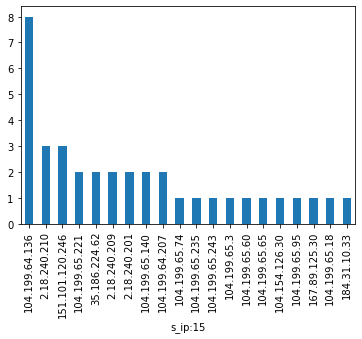

In [6]:
# Point 8.2
# Plot the number of distinct sub-services for each server IP
sp_IP_subservs = sp_dataf.groupby(['s_ip:15']).nunique().sort_values('hostname', ascending=False)
sp_IP_subservs['hostname'].head(20).plot(kind='bar')


<AxesSubplot:xlabel='s_ip:15,hostname'>

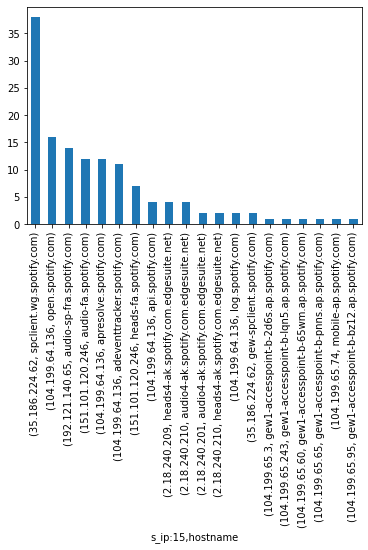

In [7]:
# task 9
sp_IP_serv_dataf = sp_dataf.groupby(['s_ip:15', 'hostname']).size()
sp_IP_serv_dataf.sort_values(ascending=False).head(20).plot(kind='bar')

Task 10
How many distinct clients access the service in total?
How many distinct clients access each server IP address ? Plot in decreasing order the number of clients for
each IP server address (If server IPs are more than 20, plot the top-20).
How many distinct clients access each subservice? Plot in decreasing order the number of clients for each
subservice (If subservices are more than 20, plot the top-20).

<AxesSubplot:xlabel='s_ip:15'>

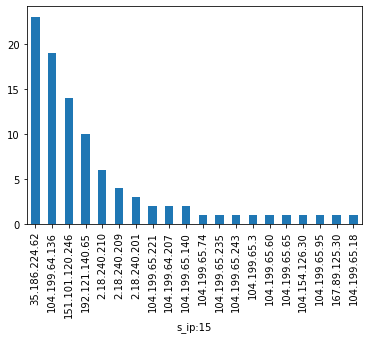

In [23]:
# clients -> local traffic
# part 1
sp_clients_IP = sp_dataf[(sp_dataf['c_isint:38'] == 1)].groupby(['s_ip:15']).nunique().sort_values('#15#c_ip:1', ascending=False)
sp_clients_IP['#15#c_ip:1'].head(20).plot(kind='bar')


In [ ]:
# part 2
sp_clients_host = sp_dataf[(sp_dataf['c_isint:38'] == 1)].groupby(['hostname']).nunique().sort_values('#15#c_ip:1', ascending=False)
sp_clients_host['#15#c_ip:1'].head(20).plot(kind='bar')

11. How many bytes were exchanged from the clients to the servers (uplink) in total? How many bytes were
exchanged from the servers to the clients (downlink) in total?
Which fraction of the clients exchanged with the service more than 1MB in total (uplink+downlink)?

In [37]:
# 9 c2s 23 s2c
sp_c2s_bytes = sp_dataf['c_bytes_all:9'].sum()
sp_s2c_bytes = sp_dataf['s_bytes_all:23'].sum()
print(sp_c2s_bytes, "Bytes from clients to servers,", sp_s2c_bytes, "Bytes from servers to clients.")

3570616 Bytes from clients to servers, 236165577 Bytes from servers to clients.


12. Count the total number of bytes handled by each server IP address. Compute this separately for the
uplink (client to server) and the downlink (server to client). Plot these two metrics, ordered by decreasing
number of bytes (If server IPs are more than 20, plot the top-20).

Repeat the same for sub-services.

In [ ]:
# part 1
sp_IP_bytes_ul = sp_dataf.groupby(['s_ip:15'])['c_bytes_all:9'].sum().sort_values(ascending=False).head(20).plot(kind='bar')


In [ ]:
# part 2
sp_IP_bytes_dl = sp_dataf.groupby(['s_ip:15'])['s_bytes_all:23'].sum().sort_values(ascending=False).head(20).plot(kind='bar')

# un solo utente stava usando durante questo time interval, questo è giustificato dal traffico di
#bytes e da un solo ip sensato quas sotto. Gli altri possono essere indirizzi locali rilevati dalle
# sonde

13. For each server IP, extract the minimum of the minimum RTT and average of the average RTT from the
client to the server. Plot them, sorted from the one handling the most clients (see exercise 10), to the least.
(If server IPs are more than 20, plot the top-20) Can you estimate at which distance the servers are? How?

<AxesSubplot:xlabel='s_ip:15'>

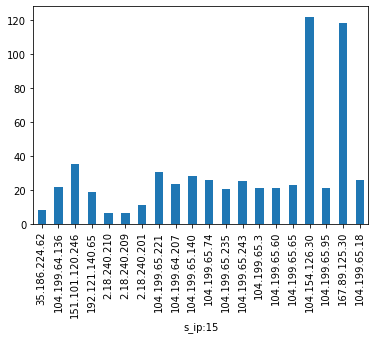

In [28]:
sp_stats_df = sp_dataf[(sp_dataf['c_isint:38'] == 1)]\
    .groupby(['s_ip:15']).agg({'#15#c_ip:1':'nunique', 'c_rtt_min:46':'min', 'c_rtt_avg:45':'mean'}).sort_values('#15#c_ip:1', ascending=False)
sp_stats_df['c_rtt_avg:45'].head(20).plot(kind='bar')

14. Plot a scatter plot, considering a point for each sub-service, characterized by the number of connections and the number of exchanged bytes each. Are there subservices that handle a lot of connections, but little data? Comment on the plot (you might use log scale for the bytes).

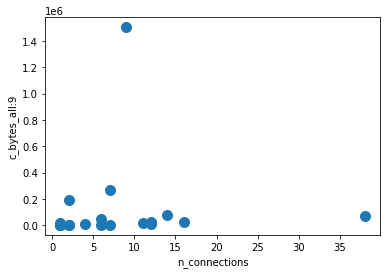

In [36]:
temp = sp_dataf.groupby(['hostname']).agg({'hostname':'size', 'c_bytes_all:9':'sum'}).rename(columns={"hostname": "n_connections"})\
    .sort_values('n_connections', ascending=False).head(20)\
    .plot.scatter(x='n_connections',y='c_bytes_all:9', s=100)

#print(temp)

15. Plot a heatmap representing the number of bytes exchanged between the top-20 most active clients (in terms of number of connections) and the top-20 most contacted sub-services (in terms of number of connections). Select a proper colormap and scale and annotate the cells with whole numbers. Comment on the plot.

In [56]:
top_clients = sp_dataf.groupby(['#15#c_ip:1']).size().sort_values(ascending=False).head(20)
top_services = sp_dataf.groupby(['hostname']).size().sort_values(ascending=False).head(20)

temp = sp_dataf[(sp_dataf['#15#c_ip:1'].isin(top_clients.keys()) & sp_dataf['hostname'].isin(top_services.keys()))]
table = pd.pivot_table(\
                       temp,\
                       values='c_bytes_all:9', index=['#15#c_ip:1', 'hostname'],\
                       aggfunc=np.sum)
print(table)

NameError: name 'np' is not defined

16. For each sub-service, plot a boxplot of the distribution of the fraction of retransmitted packets from the
client to the server and vice-versa. Is there a sub-service with a lot of retransmitted packets? What could be
possible reasons for a large number of retransimissions?

In [54]:
(sp_dataf['#15#c_ip:1'] in list(top_clients.keys()))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

17. Draw the empirical Probability Distribution Function (PDF) and the empirical Cumulative Distribution
Function (CDF) of the RTT (server to client, you can choose between minimum, average or maximum). The
PDF should be estimated either with a histogram or with a proper density estimation. The CDF should be
computed precisely (see lecture slides).

18. Play with the other columns. Which analysis do you think would be interesting? (I) Propose some analyses, (ii) show its results, (iii) comment on the findings.

In [14]:
list(sp_dataf.columns)

['#15#c_ip:1',
 'c_port:2',
 'c_pkts_all:3',
 'c_rst_cnt:4',
 'c_ack_cnt:5',
 'c_ack_cnt_p:6',
 'c_bytes_uniq:7',
 'c_pkts_data:8',
 'c_bytes_all:9',
 'c_pkts_retx:10',
 'c_bytes_retx:11',
 'c_pkts_ooo:12',
 'c_syn_cnt:13',
 'c_fin_cnt:14',
 's_ip:15',
 's_port:16',
 's_pkts_all:17',
 's_rst_cnt:18',
 's_ack_cnt:19',
 's_ack_cnt_p:20',
 's_bytes_uniq:21',
 's_pkts_data:22',
 's_bytes_all:23',
 's_pkts_retx:24',
 's_bytes_retx:25',
 's_pkts_ooo:26',
 's_syn_cnt:27',
 's_fin_cnt:28',
 'first:29',
 'last:30',
 'durat:31',
 'c_first:32',
 's_first:33',
 'c_last:34',
 's_last:35',
 'c_first_ack:36',
 's_first_ack:37',
 'c_isint:38',
 's_isint:39',
 'c_iscrypto:40',
 's_iscrypto:41',
 'con_t:42',
 'p2p_t:43',
 'http_t:44',
 'c_rtt_avg:45',
 'c_rtt_min:46',
 'c_rtt_max:47',
 'c_rtt_std:48',
 'c_rtt_cnt:49',
 'c_ttl_min:50',
 'c_ttl_max:51',
 's_rtt_avg:52',
 's_rtt_min:53',
 's_rtt_max:54',
 's_rtt_std:55',
 's_rtt_cnt:56',
 's_ttl_min:57',
 's_ttl_max:58',
 'p2p_st:59',
 'ed2k_data:60',
 'ed